# Video pipeline reading labelled videos from a directory 

### Goal
In this example, we will go through the creation of a pipeline using the **VideoReader** operator to read videos along with their labels.
The pipeline will return a pair of outputs from **VideoReader**: a batch of sequences and respective labels.

For more information on the **VideoReader** parameters, please look at the documentation reference.

To make it clearer, let's look at how we can obtain these sequences and how to use them!

### Setting up

First let's start with the imports:

In [1]:
from __future__ import print_function
from __future__ import division
import os
import numpy as np

from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types

We need some video containers to process. We can use [Sintel](https://en.wikipedia.org/wiki/Sintel) trailer, which is a mp4 video container containing a h264 and under the Create Common license. Let's split it into 5 second clips and divide the clips into labelled groups. This can be done easily with the `ffmpeg` standalone tool.

In [2]:
%%bash
mkdir -p labelled_videos/                                                                                                      
                                                                                                                               
container_name=prepared.mp4                                                                                                    
                                                                                                                               
# Download video sample                                                                                                        
wget -q -O ${container_name} https://download.blender.org/durian/trailer/sintel_trailer-720p.mp4                               
                                                                                                                               
IFS='.' read -a splitted <<< "$container_name"                                                                                 

mkdir -p labelled_videos/{0..2}
for i in {0..9};                                                                                                               
do                                                                                                                             
    ffmpeg -ss 00:00:$((i*5)) -t 00:00:05 -i $container_name -vcodec copy -acodec copy -y labelled_videos/$((i % 3))/${splitted[0]}_$i.${splitted[1]}
done                                                                                                                           

Then we can set the parameters that will be used in the pipeline. The `count` parameter will define how many frames we want in each sequence sample.

We can replace `video_directory` with any other directory containing labelled subdirectories and video container files recognized by **FFmpeg**.

In [3]:
batch_size=2
sequence_length=8

initial_prefetch_size=11

video_directory = "labelled_videos"

shuffle=True

n_iter=6

### Running the pipeline

We can then define a minimal Pipeline that will output directly the VideoReader outputs:

In [4]:
class VideoPipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, data, shuffle):
        super(VideoPipe, self).__init__(batch_size, num_threads, device_id, seed=16)
        self.input = ops.VideoReader(device="gpu", file_root=data, sequence_length=sequence_length,
                                     shard_id=0, num_shards=1,
                                     random_shuffle=shuffle, initial_fill=initial_prefetch_size)


    def define_graph(self):
        output, labels = self.input(name="Reader")
        return output, labels

Caution: One important here is tuning `initial_fill`, that correspond to the **Loader** prefetch buffer intial size. Since this buffer will be filled of `initial_fill` sequences, the total number of frames can be really huge! So set it consequently to not OOM during training.

Let's try to build and run a `VideoPipe` on device 0 that will output `batch_size` sequences of `count` frames and `batch_size` labels at each iteration.


In [5]:
pipe = VideoPipe(batch_size=batch_size, num_threads=2, device_id=0, data=video_directory, shuffle=shuffle)
pipe.build()
for i in range(n_iter):
    sequences_out, labels = pipe.run()
    sequences_out = sequences_out.as_cpu().as_array()
    labels = labels.as_cpu().as_array()
    print(sequences_out.shape)
    print(labels.shape)

(2, 8, 720, 1280, 3)
(2, 1)
(2, 8, 720, 1280, 3)
(2, 1)
(2, 8, 720, 1280, 3)
(2, 1)
(2, 8, 720, 1280, 3)
(2, 1)
(2, 8, 720, 1280, 3)
(2, 1)
(2, 8, 720, 1280, 3)
(2, 1)


### Visualizing the results

The previous iterations seems to have the yield batches of the expected shape. But let's visualize the results to be

In [6]:
sequences_out, labels = pipe.run()
sequences_out = sequences_out.as_cpu().as_array()
labels = labels.as_cpu().as_array()

We will use matplotlib to display the frames we obtained in the last batch.

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [8]:
def show_sequence(sequence, label):
    columns = 4
    rows = (sequence_length + 1) // (columns)
    fig = plt.figure(figsize = (32,(16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.suptitle("label " + str(label[0]), fontsize=30)
        plt.imshow(sequence[j])

And now let's generate 5 batches of sequence, label pairs:

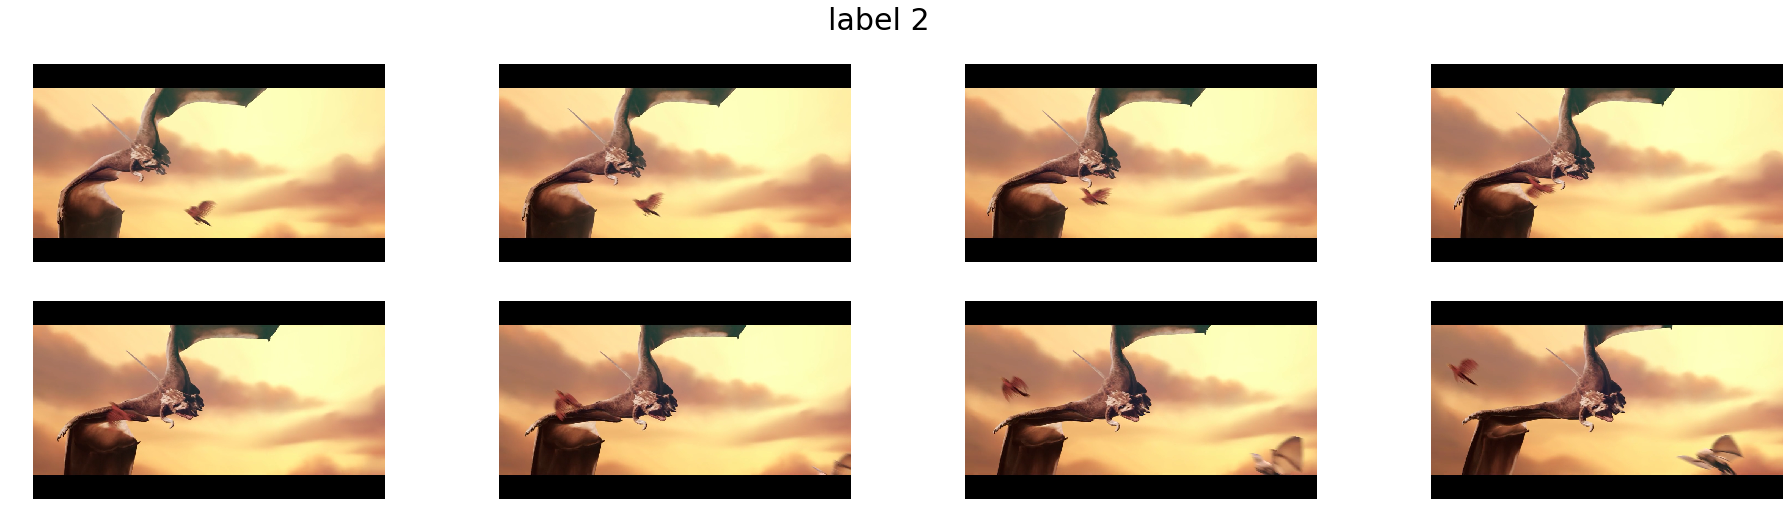

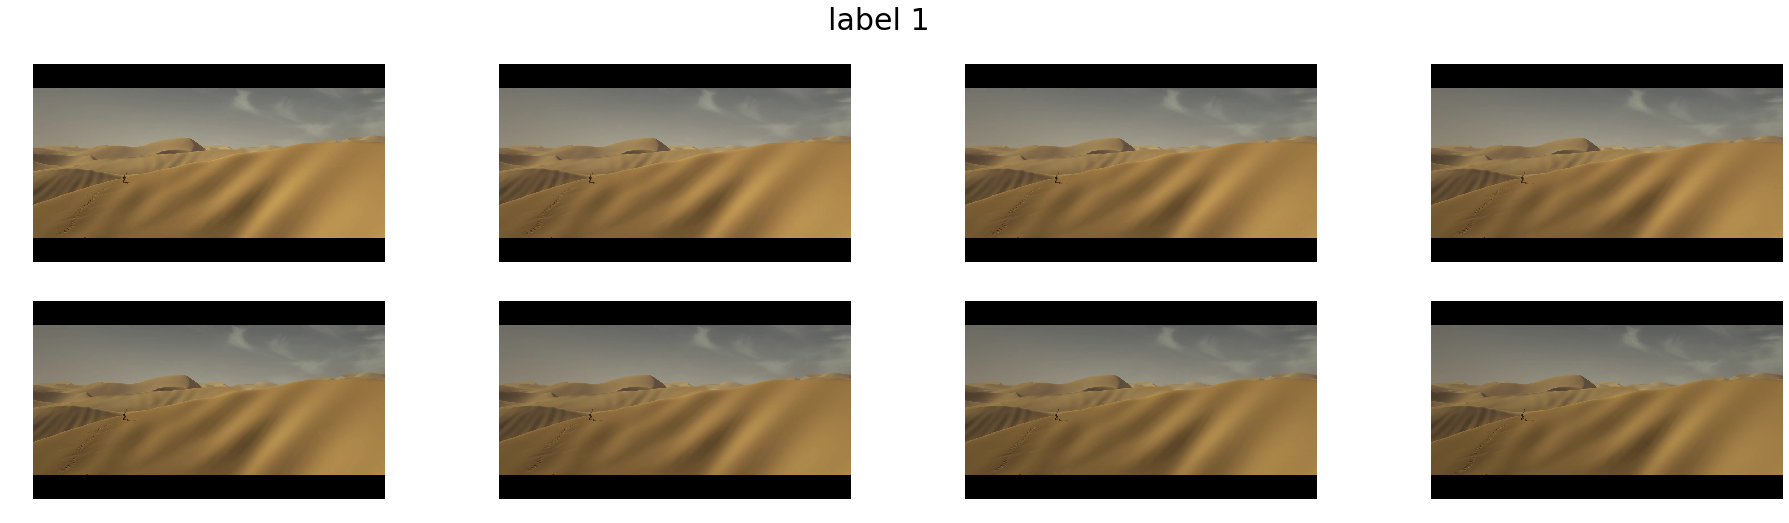

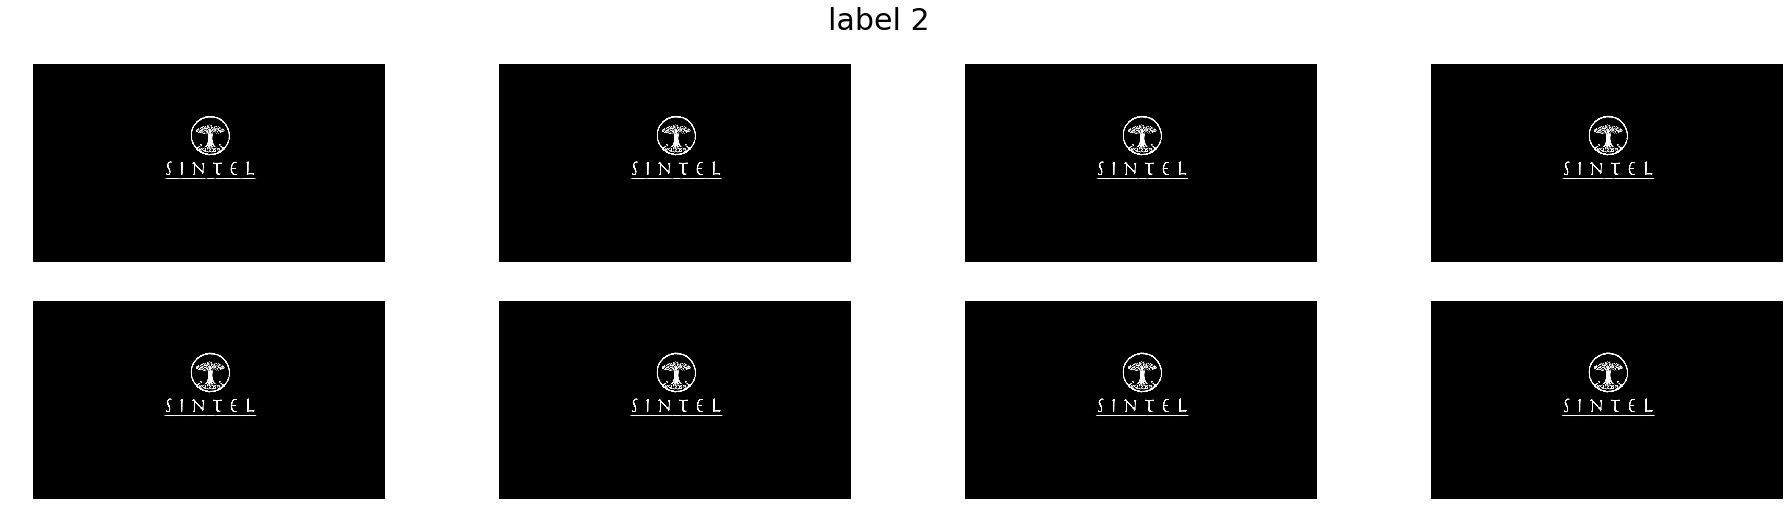

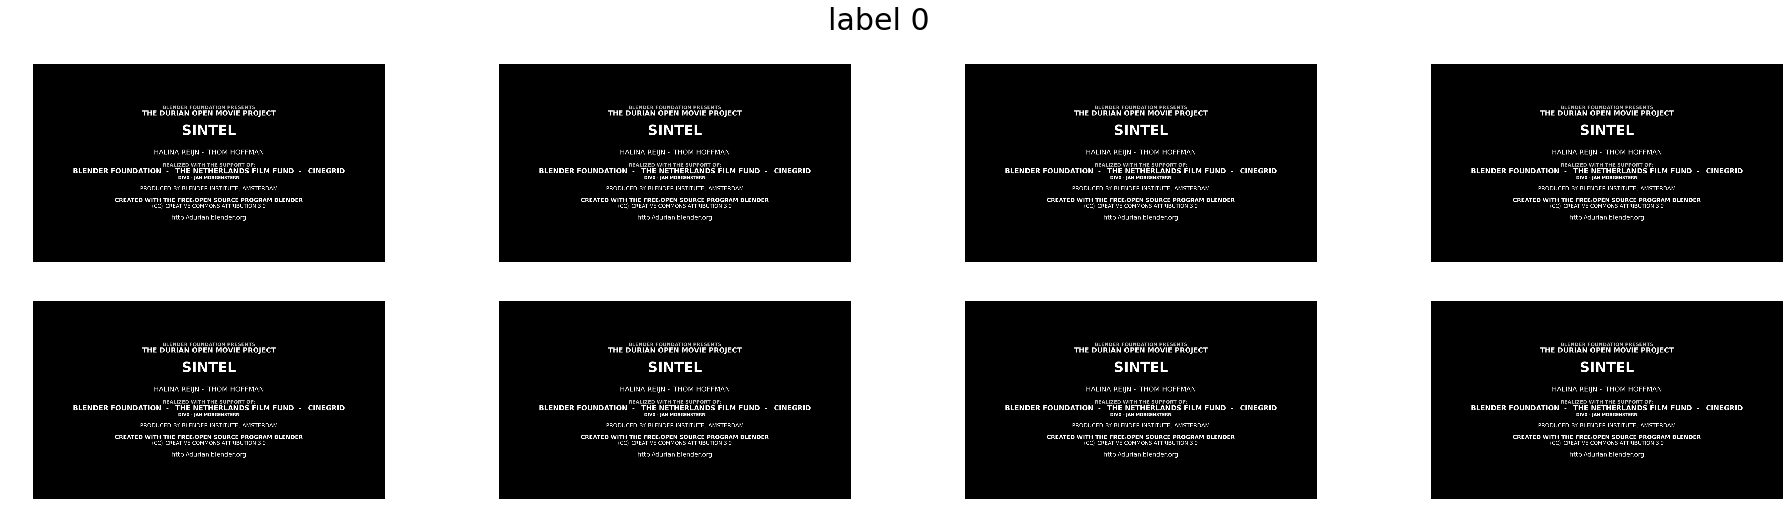

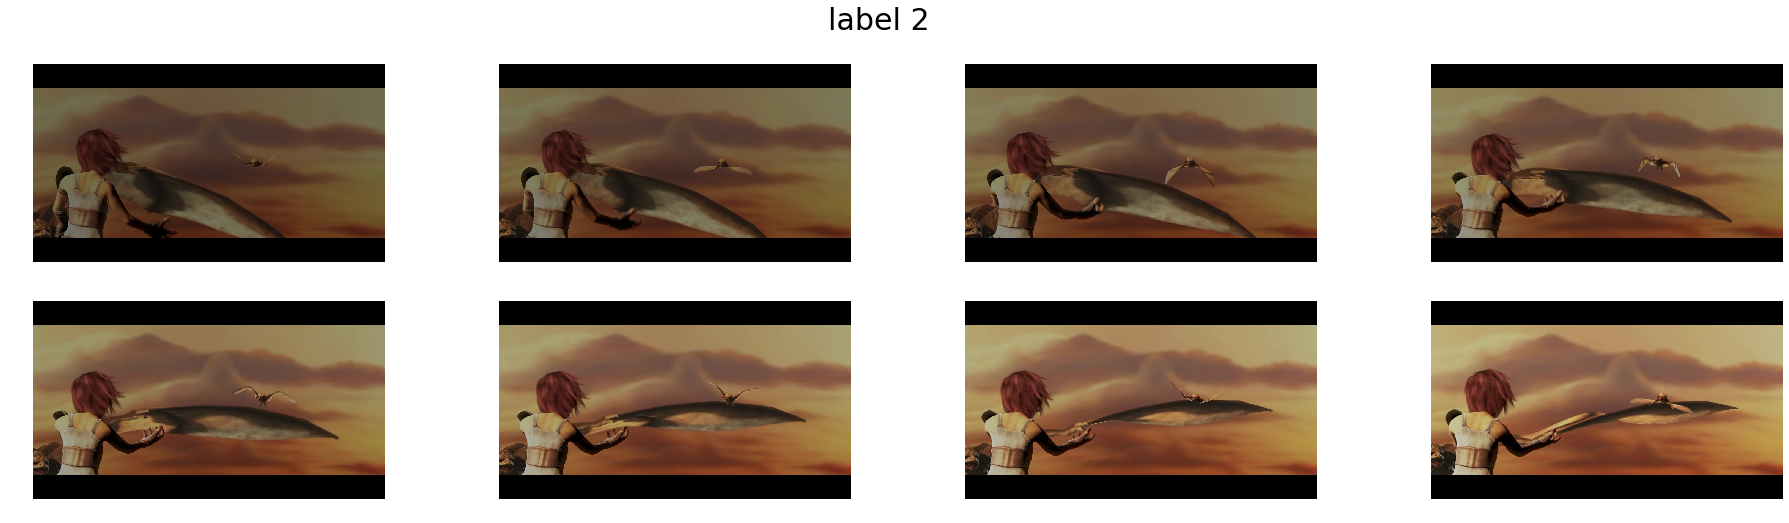

In [9]:
ITER = 5
for i in range(ITER):
    sequences_out, labels = pipe.run()
    sequences_out = sequences_out.as_cpu().as_array()
    labels = labels.as_cpu().as_array()
    show_sequence(sequences_out[1], labels[1])